# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization, CropOrPad, ToCanonical)

from sklearn.metrics import f1_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from Functions_classification_training import UNet_1_layer, UNet_2_layer, Classifier

In [2]:
with open('../subjects_dict.pkl', 'rb') as f:
    subjects_dict = pickle.load(f)

In [3]:
# Remove CHP1 and ACH1 from dictionary
subjects_dict['CHIASM']['control'].remove('CHP1')
subjects_dict['CHIASM']['control'].remove('ACH1')

In [4]:
# Explorative analysis will use 80/10/10 (train/dev_train/test) split
# The number of albinism samples in train & dev_train datasets will be upsampled to match number of data in train/dev_train

# Assign the participants to train/dev_train/dev_test/test groups for the purpose of AE training

split=[0.0,0.8,0.9,1.0]

groups=['train','dev_train', 'test']

design_expl_classifier_training={}

for i in range(len(groups)):
    
    design_expl_classifier_training[groups[i]]={}
    
    for dataset in subjects_dict.keys():
        
        design_expl_classifier_training[groups[i]][dataset]={}
        
        for label in subjects_dict[dataset].keys():
            
            design_expl_classifier_training[groups[i]][dataset][label]={}
            
            number_participants = len(subjects_dict[dataset][label])
            start = np.int(np.floor(number_participants*split[i]))
            end = np.int(np.floor(number_participants*split[i+1]))

            #print(groups[i],dataset,len(subjects_dict[dataset]['control'][start:end]))
            design_expl_classifier_training[groups[i]][dataset][label]=subjects_dict[dataset][label][start:end]
                 
# Check the number of participants in each group
for group in design_expl_classifier_training.keys():
    for dataset in design_expl_classifier_training[group].keys():
        for label in design_expl_classifier_training[group][dataset].keys():
            print(group, dataset,label,len(design_expl_classifier_training[group][dataset][label]))
            
# Save the dict
with open('design_expl_classifier_training.pkl', 'wb') as f:
    pickle.dump(design_expl_classifier_training, f)

train ABIDE control 284
train Athletes control 33
train HCP control 852
train COBRE control 48
train Leipzig control 106
train UoN control 16
train UoN albinism 18
train CHIASM control 6
train CHIASM albinism 7
train MCIC control 20
dev_train ABIDE control 35
dev_train Athletes control 4
dev_train HCP control 106
dev_train COBRE control 6
dev_train Leipzig control 13
dev_train UoN control 2
dev_train UoN albinism 2
dev_train CHIASM control 1
dev_train CHIASM albinism 1
dev_train MCIC control 2
test ABIDE control 36
test Athletes control 5
test HCP control 107
test COBRE control 6
test Leipzig control 14
test UoN control 2
test UoN albinism 3
test CHIASM control 1
test CHIASM albinism 1
test MCIC control 3


In [5]:
with open('design_expl_classifier_training.pkl', 'rb') as f:
    design_expl_classifier_training = pickle.load(f)

In [6]:
#for group in design_expl_classifier_training.keys():
#    for dataset in design_expl_classifier_training[group].keys():
#        for label in design_expl_classifier_training[group][dataset].keys():
#            print(group, dataset,label,len(design_expl_classifier_training[group][dataset][label]))

In [7]:
# Torchio's subjects' dictionary + upsample the albinism group, so it matches controls in train and dev_train + add labels

dict_expl_classifier_training={}

for group in design_expl_classifier_training.keys():
    
    dict_expl_classifier_training[group]=[]
    
    # Calculate the number of albinism and controls, calculate the scaling coefficient
    num_control=0
    num_albinism=0
    
    for dataset in design_expl_classifier_training[group].keys():
            
        num_control+=len(design_expl_classifier_training[group][dataset]['control'])
        
        if dataset in ['CHIASM', 'UoN']:
            num_albinism+=len(design_expl_classifier_training[group][dataset]['albinism'])
    
    scaling_factor=int(num_control/num_albinism)
    
    # Create Torchio's subject for listed IDs, for train & dev_train upsample the albinism
    for dataset in design_expl_classifier_training[group].keys():
        
        # If test just aggregate all the data
        if group=='test':
             
            for label in design_expl_classifier_training[group][dataset].keys():
                
                if label=='albinism':
                    label_as=1
                elif label=='control':
                    label_as=0
                
                dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                    label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]
    
        # otherwise upsample albinism by calculated scaling_factor
        else:
            
            for label in design_expl_classifier_training[group][dataset].keys():
                
                if label=='control':
                    
                    label_as=0
                    
                    dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                    label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]
    
                if label=='albinism':
                    
                    label_as=1
                    
                    for i in range(scaling_factor):
                    
                        dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                        label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]    

In [8]:
# Histogram standardization (to mitigate cross-site differences)
chiasm_paths=[]

# Obtain paths of all chiasm images
for group in design_expl_classifier_training.keys():
    for dataset in design_expl_classifier_training[group].keys():
        for label in design_expl_classifier_training[group][dataset].keys():
            for subject in design_expl_classifier_training[group][dataset][label]:
                chiasm_paths.append('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz')

chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)

100%|██████████| 1740/1740 [00:01<00:00, 1023.62it/s]


In [9]:
# Data preprocessing and augmentation

# Canonical
canonical = ToCanonical()

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.5)

# Affine transformations
affine = tio.RandomAffine(degrees=5, translation=(2,2,2), center='image')

crop = CropOrPad((24,24,8))

# Elastic deformation
#elastic = tio.transforms.RandomElasticDeformation(num_control_points=4, max_displacement=4, locked_borders=1)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([canonical, standardize, rescale, affine, flip, crop])
transform_dev = Compose([canonical, standardize, rescale, crop])

In [10]:
datasets_list={}

for group in dict_expl_classifier_training.keys():
    
    if group =='train':
    
        datasets_list[group] = tio.SubjectsDataset(dict_expl_classifier_training[group], transform=transform_train)
        
    else:
        
        datasets_list[group] = tio.SubjectsDataset(dict_expl_classifier_training[group], transform=transform_dev)

In [11]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=datasets_list['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=datasets_list['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'test': DataLoader(dataset=datasets_list['test'], batch_size=10, shuffle=True, num_workers=8)}


## Input sample

train


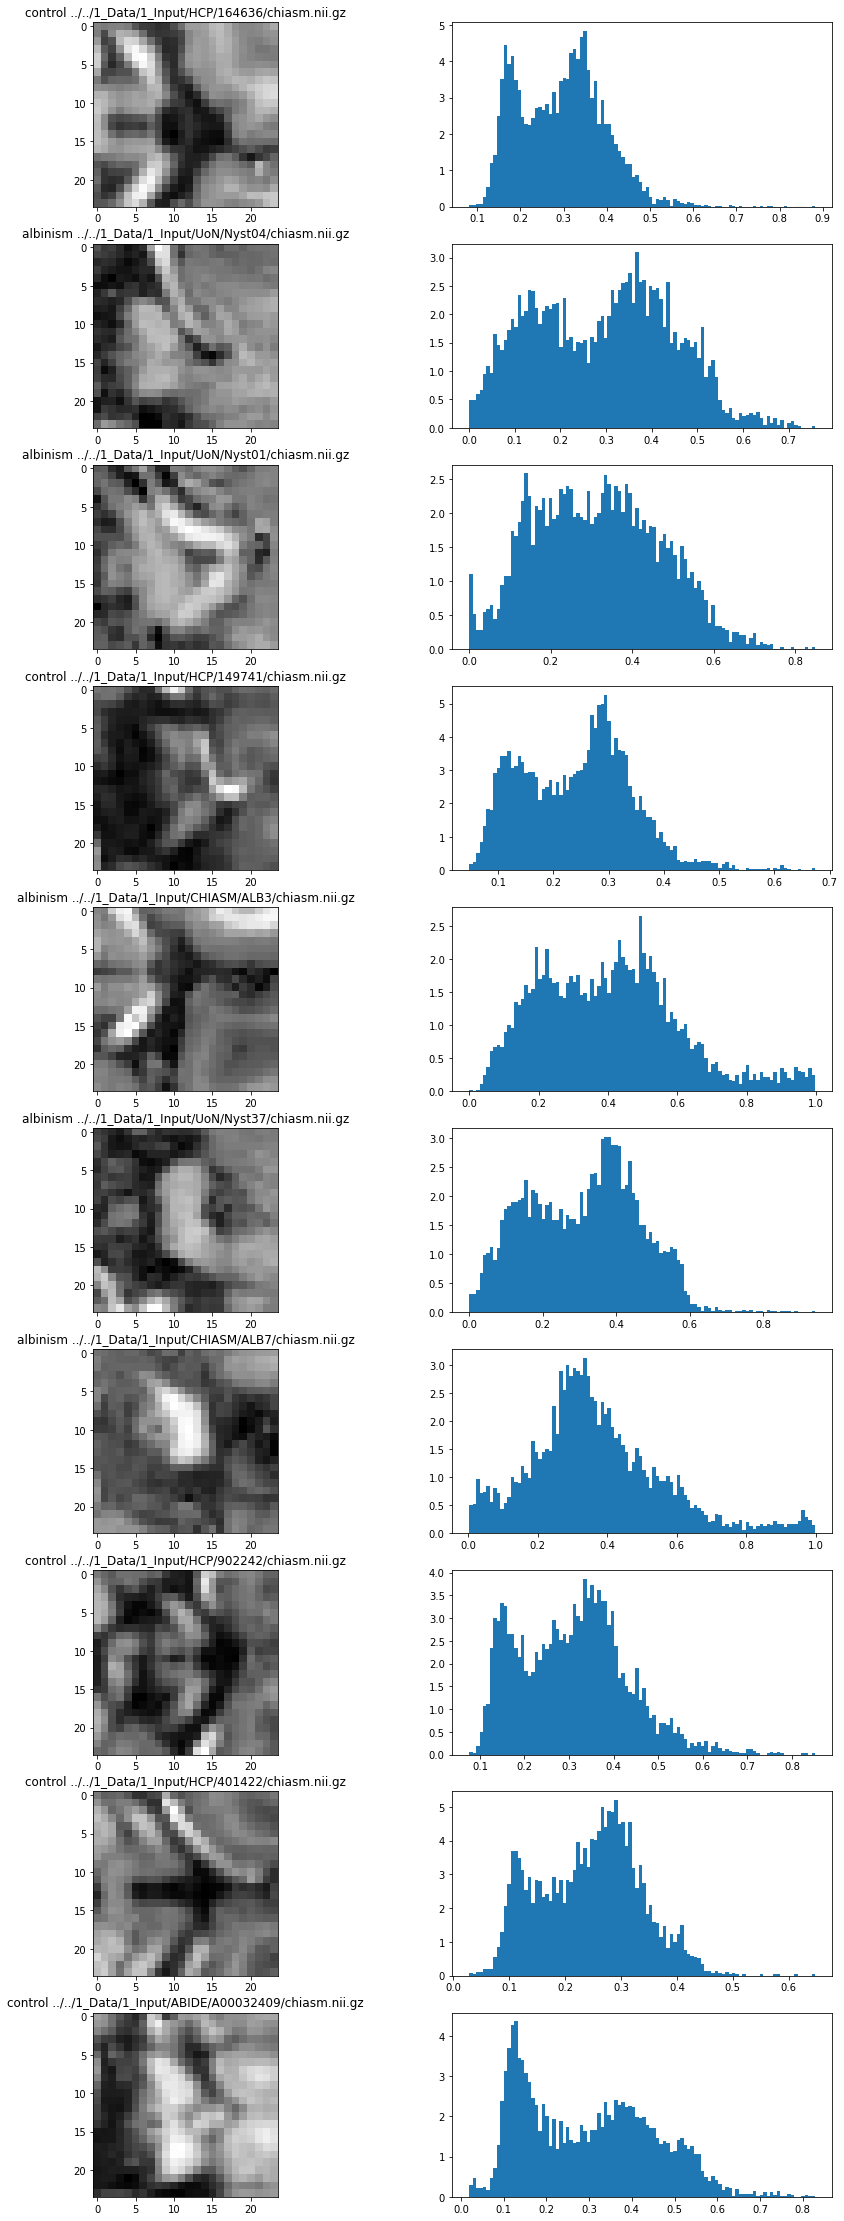

dev_train


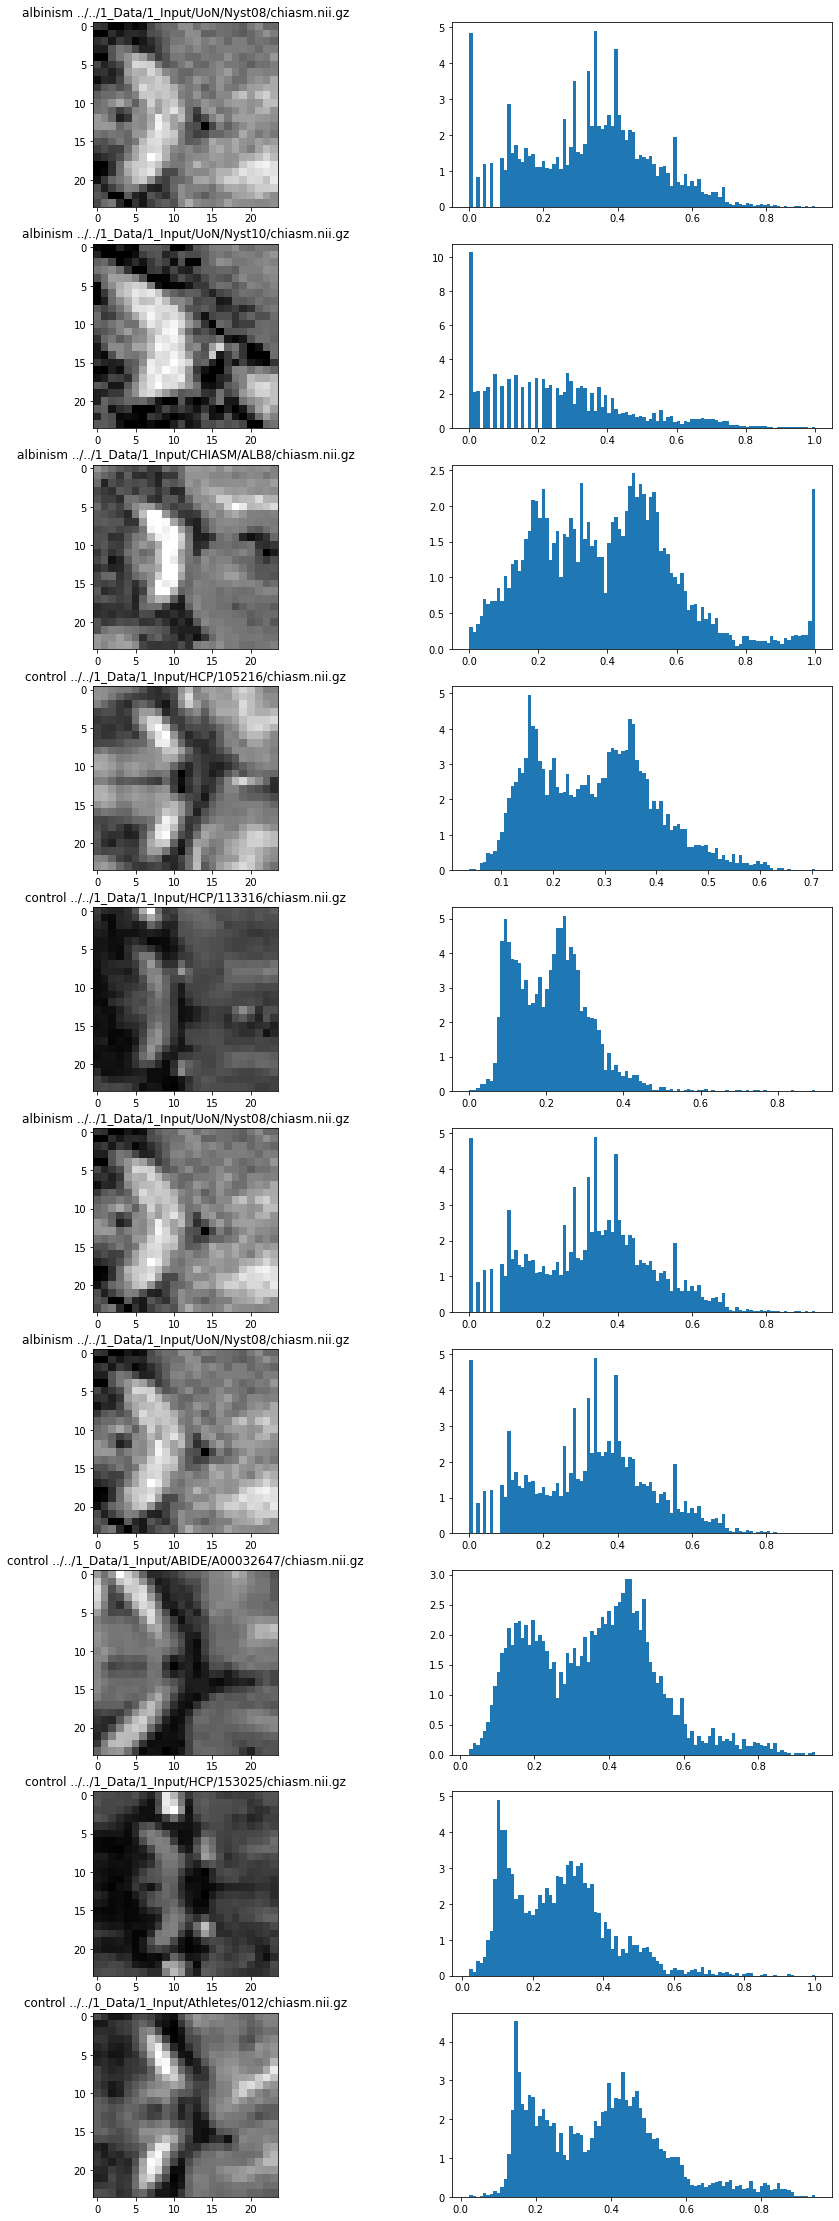

test


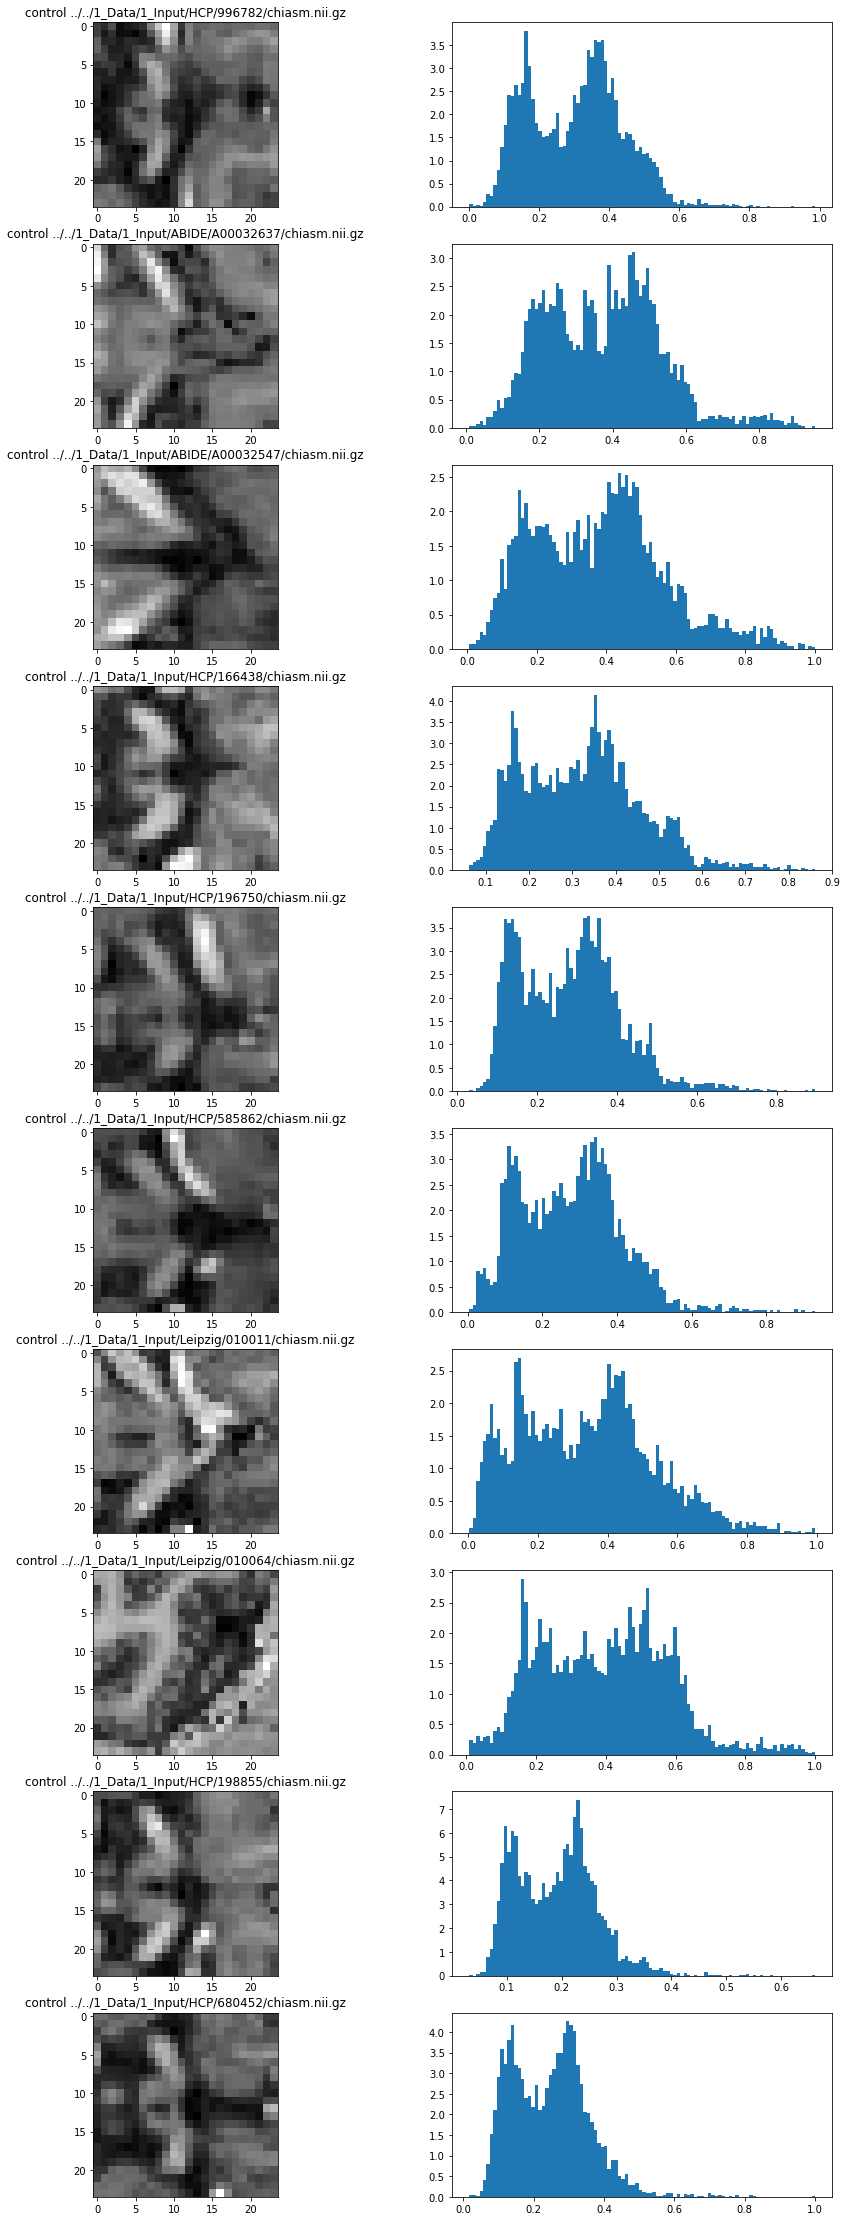

In [12]:
# Visualize sample

classes=['control','albinism']

for group in ['train', 'dev_train', 'test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(15,40))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]]+' '+batch[1]['chiasm']['path'][i])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

## Average input

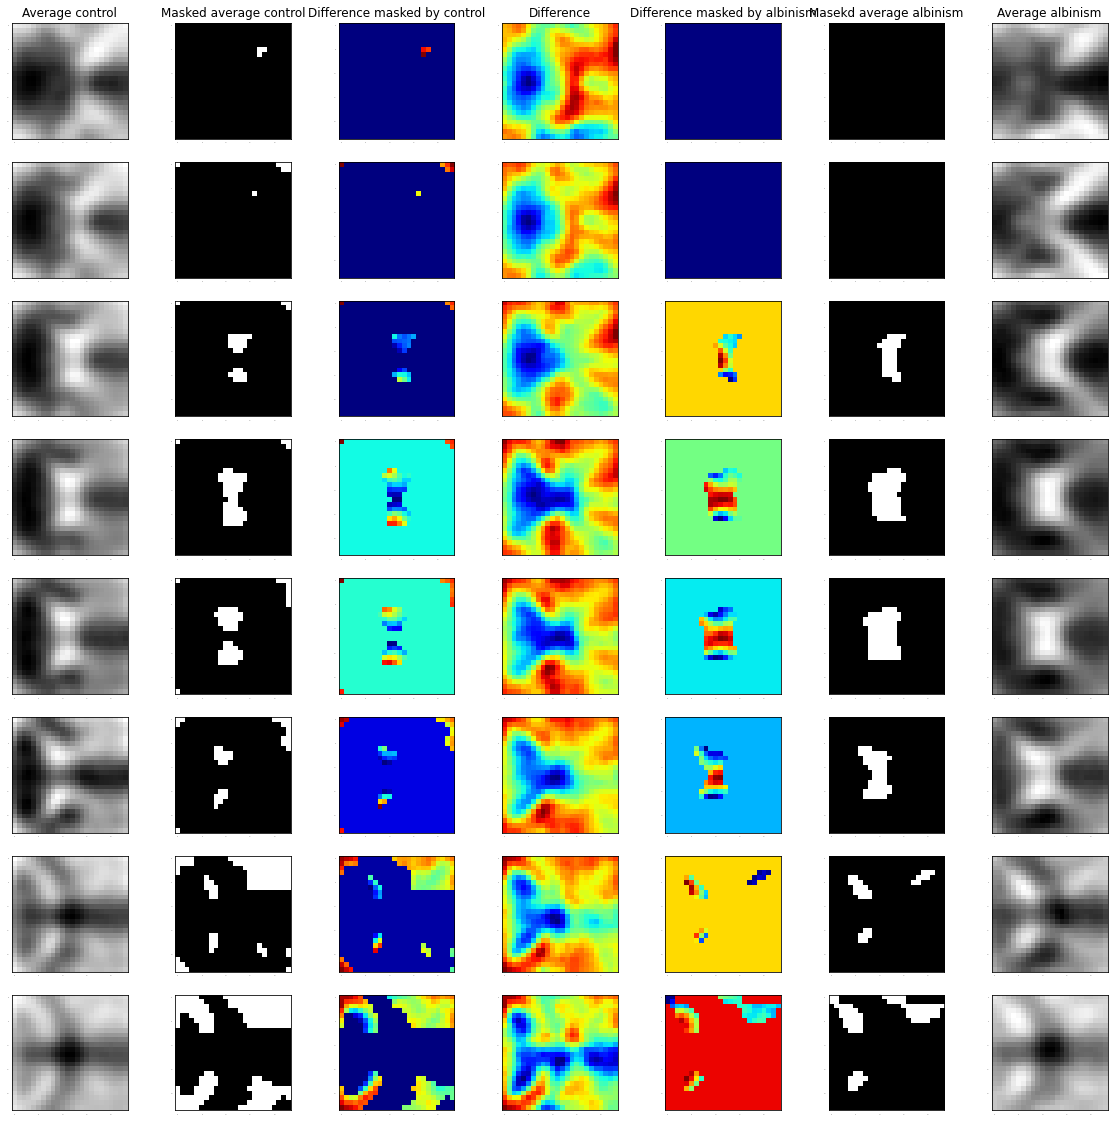

In [13]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
# Normalize albinism
maximal = np.max(average_albinism)
minimal = np.min(average_albinism)
average_albinism = (average_albinism - minimal)/(maximal - minimal)

# Normalize control
maximal = np.max(average_control)
minimal = np.min(average_control)
average_control = (average_control - minimal)/(maximal - minimal)

plt.figure(figsize=(20,20))

num_of_columns=7

for i in range(8):
        
    # Control
    plt.subplot(8,num_of_columns,num_of_columns*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
        
    # Control masked
    plt.subplot(8,num_of_columns,num_of_columns*i+2)
    plt.imshow(average_control[:,:,i]>0.775, cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Masked average control')
        
    # Difference masked by control
    plt.subplot(8,num_of_columns,num_of_columns*i+3)
    plt.imshow((average_control[:,:,i]-average_albinism[:,:,i])*(average_control[:,:,i]>0.775), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference masked by control')
        
    # Difference control - albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+4)
    plt.imshow(average_control[:,:,i]-average_albinism[:,:,i], cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')
        
    # Difference masked by albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+5)
    plt.imshow((average_albinism[:,:,i]-average_control[:,:,i])*(average_albinism[:,:,i]>0.7), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference masked by albinism')
        
    # Albinism masked
    plt.subplot(8,num_of_columns,num_of_columns*i+6)
    plt.imshow(average_albinism[:,:,i]>0.70, cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Masekd average albinism')
        
          
    # Albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+7)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')

## Average encoded input

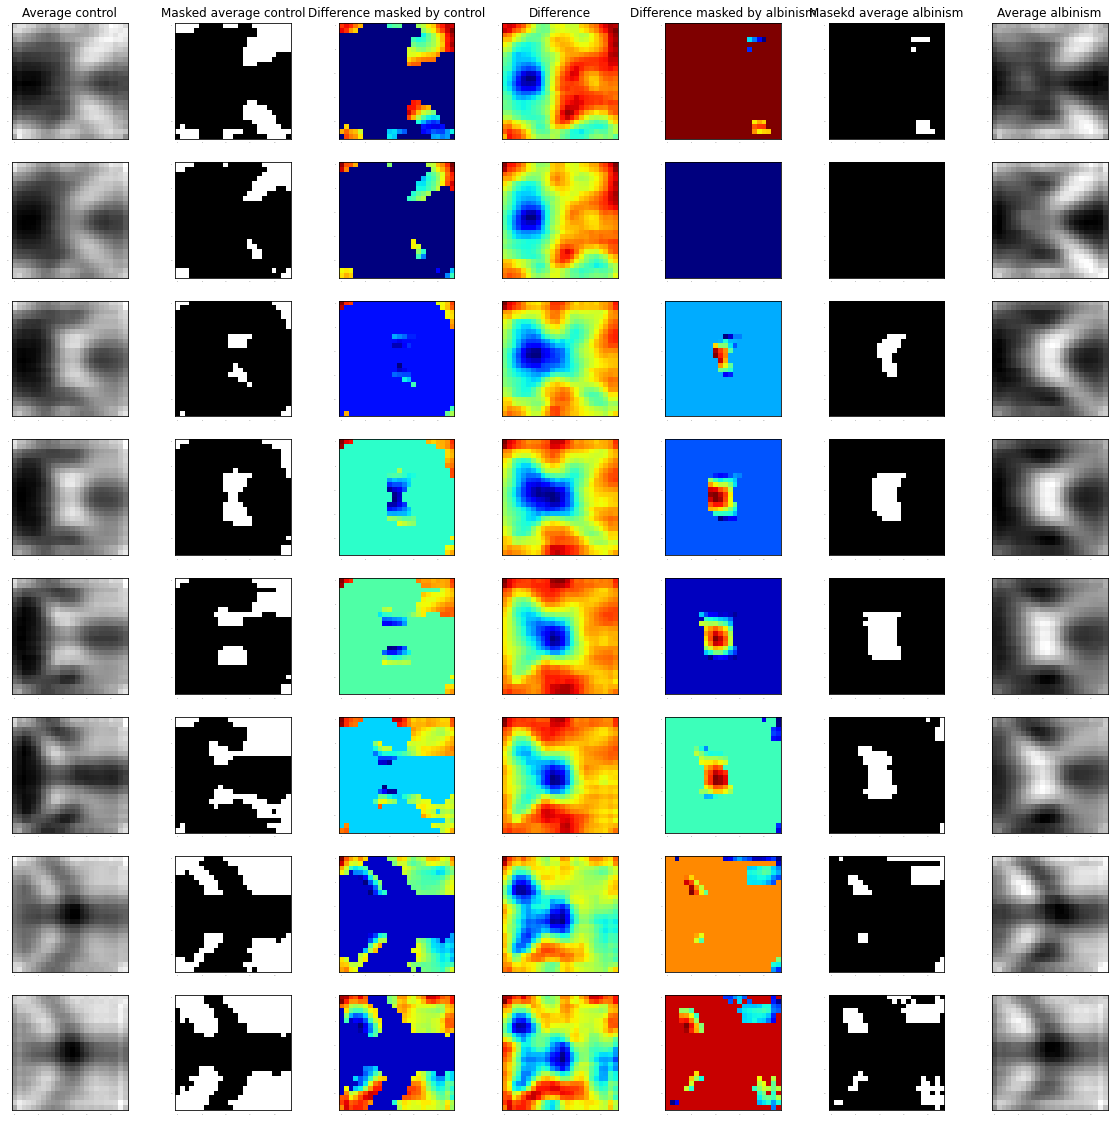

In [14]:
# Calculate average input after AE step

ae = UNet_1_layer(1,1,2,2)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))

 
# Normalize albinism
maximal = np.max(average_albinism)
minimal = np.min(average_albinism)
average_albinism = (average_albinism - minimal)/(maximal - minimal)

# Normalize control
maximal = np.max(average_control)
minimal = np.min(average_control)
average_control = (average_control - minimal)/(maximal - minimal)

plt.figure(figsize=(20,20))

num_of_columns=7

for i in range(8):
        
    # Control
    plt.subplot(8,num_of_columns,num_of_columns*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
        
    # Control masked
    plt.subplot(8,num_of_columns,num_of_columns*i+2)
    plt.imshow(average_control[:,:,i]>0.7, cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Masked average control')
        
    # Difference masked by control
    plt.subplot(8,num_of_columns,num_of_columns*i+3)
    plt.imshow((average_control[:,:,i]-average_albinism[:,:,i])*(average_control[:,:,i]>0.7), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference masked by control')
        
    # Difference control - albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+4)
    plt.imshow(average_control[:,:,i]-average_albinism[:,:,i], cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')
        
    # Difference masked by albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+5)
    plt.imshow((average_albinism[:,:,i]-average_control[:,:,i])*(average_albinism[:,:,i]>0.7), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference masked by albinism')
        
    # Albinism masked
    plt.subplot(8,num_of_columns,num_of_columns*i+6)
    plt.imshow(average_albinism[:,:,i]>0.70, cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Masekd average albinism')
        
          
    # Albinism
    plt.subplot(8,num_of_columns,num_of_columns*i+7)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')

# Training

In [15]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [16]:
# Criterion
#criterion = nn.NLLLoss()
criterion = nn.BCELoss()

In [17]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    track_dev_train_loss = []
    track_test_loss = []
    
    track_train_f1 = []
    track_dev_train_f1 = []
    track_test_f1 = []
    
    valid_loss_min = np.Inf
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0
        dev_train_loss = 0.0
        test_loss = 0.0
                
        # Training
        model.train()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            
            output=model(data)
            
            loss = criterion(output.squeeze(), batch['label'].to(device).float())
            loss.backward()
            
            optimizer.step()
            
            train_loss+= (loss.item()*len(batch['label']))
            
            acc_targets+=batch['label'][:].numpy().tolist()
            acc_predictions+=output.round().detach().cpu().numpy().tolist()
            
        track_train_loss.append(train_loss/len(dict_expl_classifier_training['train']))        
        track_train_f1.append(f1_score(acc_targets, acc_predictions, average='weighted')) 
            
        # Validation on dev_train dataset
        model.eval()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['dev_train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output.squeeze(), batch['label'].to(device).float())
                
                dev_train_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.round().detach().cpu().numpy().tolist()
                
        track_dev_train_loss.append(dev_train_loss/len(dict_expl_classifier_training['dev_train']))
        track_dev_train_f1.append(f1_score(acc_targets, acc_predictions, average='weighted')) 
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['test']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output.squeeze(), batch['label'].to(device).float())
                
                test_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.round().detach().cpu().numpy().tolist()
                
        track_test_loss.append(test_loss/len(dict_expl_classifier_training['test']))
        track_test_f1.append(f1_score(acc_targets, acc_predictions, average='weighted')) 
        
        if epoch%500 ==0:
            print('END OF EPOCH: {} \n Training loss per image: {:.6f}\n Training_dev loss per image: {:.6f}\n Test_dev loss per image: {:.6f}'.format(epoch, train_loss/len(dict_expl_classifier_training['train']),dev_train_loss/len(dict_expl_classifier_training['dev_train']),test_loss/len(dict_expl_classifier_training['test'])))
            
        ## Save the model if reached min validation loss and save the number of epoch               
        if dev_train_loss < valid_loss_min:
            valid_loss_min = dev_train_loss
            torch.save(model.state_dict(),save_path+'optimal_weights')
            last_updated_epoch = epoch
        
            with open(save_path+'number_epochs.txt','w') as f:
                print('Epoch:', str(epoch), file=f)  
                
        # Early stopping
        if (epoch - last_updated_epoch) == 500:
            break
                                
    # return trained model
    return track_train_loss, track_dev_train_loss, track_test_loss, track_train_f1, track_dev_train_f1, track_test_f1

### Parameters

In [18]:
model_parameters=[[1,2,2,1,257]]

learning_rates = [0.00001]
n_epochs=5000

### Training classification layers only

In [19]:
folder='../../1_Data/3_Trained_classifier_finetuning_classification/'

for parameters in model_parameters:
    for learning_rate in learning_rates:

        # Initialize the proper model
        classifying_network = Classifier(parameters[0],parameters[1], parameters[2], parameters[3], parameters[4])
        classifying_network.freeze_feature_extraction()

        # Optimizer    
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate)
        #optimizer = torch.optim.Adam(params=classifying_network.parameters(), lr=0.00005)

        # Create output folder
        data_folder = folder+'/'+str(parameters[0])+'_'+str(parameters[1])+'_'+str(parameters[2])+'_'+str(parameters[3])+'_'+str(parameters[4])+'_'+str(learning_rate)+'/'
        os.makedirs(data_folder, exist_ok=True)

        # Train & save weights
        train_loss, dev_train_loss, test_loss, train_f1, dev_train_f1, test_f1 = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

        # Save losses
        with open(data_folder+'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)

        with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
            pickle.dump(dev_train_loss, f)

        with open(data_folder+'test_loss.pkl', 'wb') as f:
            pickle.dump(test_loss, f)

        with open(data_folder+'train_f1.pkl', 'wb') as f:
            pickle.dump(train_f1, f)

        with open(data_folder+'dev_train_f1.pkl', 'wb') as f:
            pickle.dump(dev_train_f1, f)

        with open(data_folder+'test_f1.pkl', 'wb') as f:
            pickle.dump(test_f1, f)

 10%|█         | 500/5000 [25:19<4:04:27,  3.26s/it]

END OF EPOCH: 500 
 Training loss per image: 0.054059
 Training_dev loss per image: 0.013674
 Test_dev loss per image: 0.046497


 13%|█▎        | 628/5000 [32:02<3:43:07,  3.06s/it]


KeyboardInterrupt: 